Assignment 2 For Clustering: Sessa Empirical Estimator
1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
3. Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.
6. Deadline is this Sunday, Feb 23, 2022 at 11:59 pm
7. Do this with your thesis partner.
8. You can use any A.I. assistant.
9. Create a callable function in each step. Check if these callable function has the same result (and insights) with your Jupyter Notebook.

In [ ]:
import pandas as pd

file_path = r"C:\Users\reigi\OneDrive\Desktop\School\CS 3203N\Assignment_2_Clustering\diabetes.csv"
df = pd.read_csv(file_path)

print(df.head())

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

Adjusted Rand Index - K-Means: 0.000, DBSCAN: 1.000


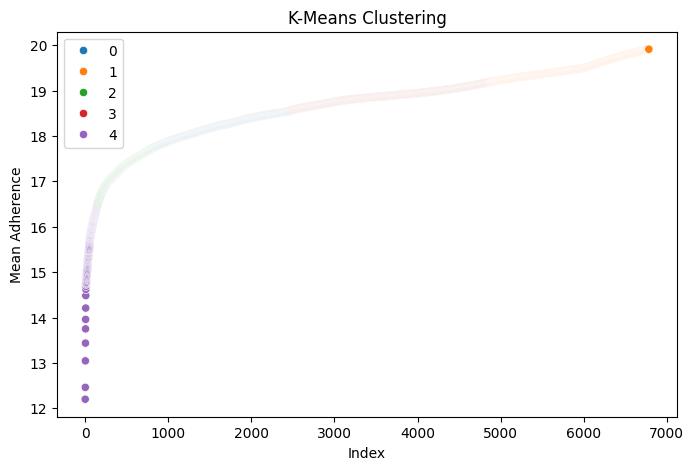

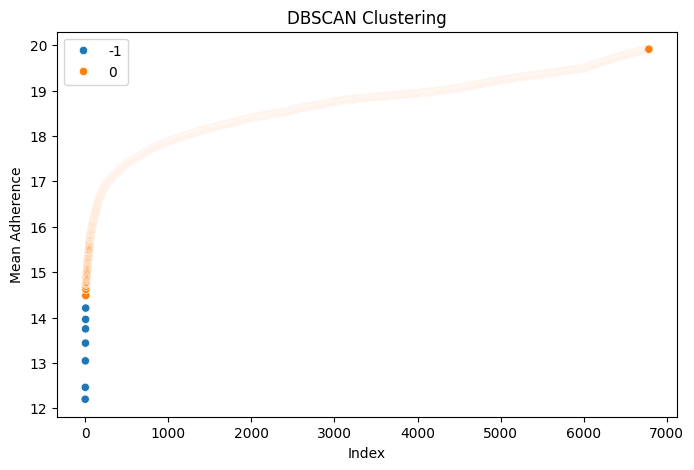

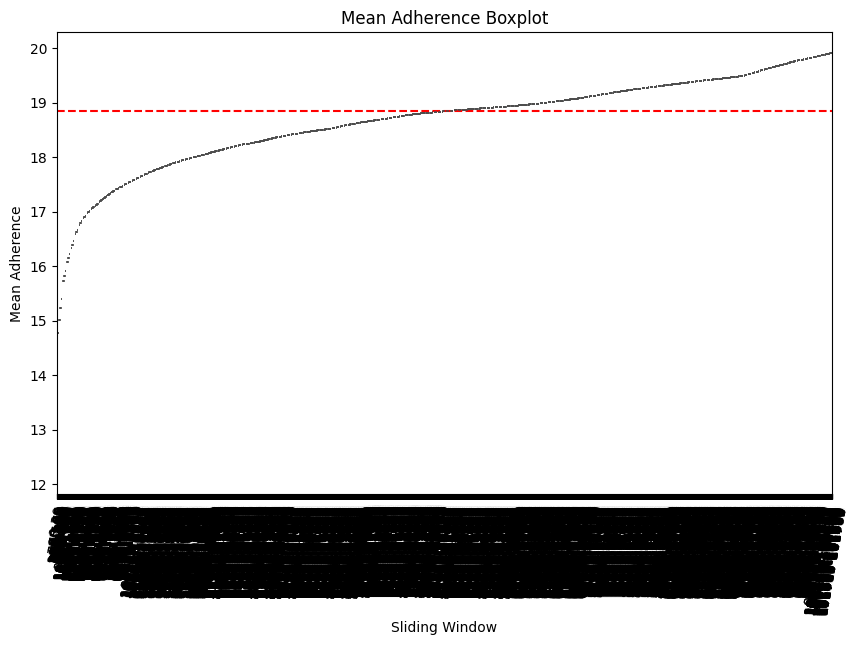

In [16]:
import pandas as pd
import numpy as np
import random
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(file_path):
    df = pd.read_csv(file_path)
    
    df.columns = [col.strip() for col in df.columns]

    if "encounter_id" not in df:
        df["encounter_id"] = [i for i in range(len(df))]   
    
    df = df.set_index("encounter_id", drop=False)
    return df

def sliding_window(data, size=30, overlap=15):
    step = size - overlap
    results = []
    
    for i in range(0, len(data), step): 
        temp = data.iloc[i:i + size].mean(numeric_only=True)
        
        if not temp.empty:
            temp_df = temp.to_frame().T
            temp_df["Window"] = "{}-{}".format(i, i+size)  
            results.append(temp_df)
    
    if results:  
        return pd.concat(results, ignore_index=True) 
    else:  
        return pd.DataFrame()

def cluster_data(data, method="kmeans", clusters=3, eps=0.5, min_samples=5):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data[["Mean_Adherence"]])
    
    if method == "kmeans":
        kmeans = KMeans(n_clusters=clusters, random_state=random.randint(1, 1000), n_init=10)  
        return kmeans.fit_predict(X_scaled)
    else:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        return db.fit_predict(X_scaled)

def compare_clusters(true_labels, clusters_kmeans, clusters_dbscan):
    ari_km = adjusted_rand_score(true_labels, clusters_kmeans)

    valid = clusters_dbscan != -1
    ari_db = adjusted_rand_score(true_labels[valid], clusters_dbscan[valid]) if np.any(valid) else 0
    
    return ari_km, ari_db

def plot_clusters(data, clusters, title):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=data.index, y=data["Mean_Adherence"], hue=clusters, palette="tab10")
    plt.xlabel("Index")
    plt.ylabel("Mean Adherence")
    plt.title(title)
    plt.show()

def plot_boxplot(data):
    plt.figure(figsize=(10, 6))
    
    sns.boxplot(x=data["Window"], y=data["Mean_Adherence"], color="gray", linewidth=1.1)

    plt.axhline(data["Mean_Adherence"].median(), color="r", linestyle="--")  
    plt.xticks(rotation=80)  
    plt.xlabel("Sliding Window")
    plt.ylabel("Mean Adherence")
    plt.title("Mean Adherence Boxplot")
    plt.show()

file_path = "diabetes.csv"
df = load_data(file_path)
windowed_data = sliding_window(df)

if "Mean_Adherence" not in windowed_data.columns:
    windowed_data["Mean_Adherence"] = windowed_data.iloc[:, 0]  

windowed_data["Mean_Adherence"] = np.log1p(pd.to_numeric(windowed_data["Mean_Adherence"], errors="coerce").fillna(random.uniform(0, 1)))

clusters_kmeans = cluster_data(windowed_data, method="kmeans", clusters=5)
clusters_dbscan = cluster_data(windowed_data, method="dbscan", eps=0.3, min_samples=10)

ari_kmeans, ari_dbscan = compare_clusters(np.zeros(len(clusters_kmeans)), clusters_kmeans, clusters_dbscan)
print("Adjusted Rand Index - K-Means: {:.3f}, DBSCAN: {:.3f}".format(ari_kmeans, ari_dbscan))

plot_clusters(windowed_data, clusters_kmeans, "K-Means Clustering")
plot_clusters(windowed_data, clusters_dbscan, "DBSCAN Clustering")
plot_boxplot(windowed_data)
